In [2]:
from PCSampler import PCSampler, vis_pc, transform_cloud
from manifpy import SE3, SO3, SE3Tangent
import open3d as o3d
import numpy as np
import tf
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:


def ellipse_params(covmat2x2):
    a = covmat2x2[0,0]
    b = covmat2x2[0,1]
    c = covmat2x2[1,1]
    width  = (a+c)/2 + np.sqrt(((a-c)/2)**2 + b**2)
    length = (a+c)/2 - np.sqrt(((a-c)/2)**2 + b**2)
    angle = 0
    if b == 0 and a >= c:
        angle = 0
    elif b == 0 and a < c:
        angle = np.pi / 2
    else:
        angle = np.arctan2(width - a, b)
    return np.sqrt(width), np.sqrt(length), angle




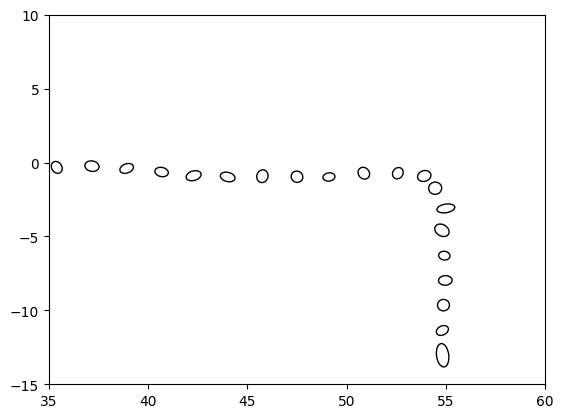

In [5]:
import pickle
samples = None
with open("tf_samples5.p", "rb") as f:
    samples = pickle.load(f)


ellipses = []
for mean, cov, T, _ in samples: 
    #print("\n", mean)
    pos = T[:2,3]
    R = T[:2,:2]
    C = R@cov[:2, :2]@R.T
    #print(C)
    w, l, a = ellipse_params(C)
    #print(pos)
    e = Ellipse((pos[0],pos[1]), w, l, angle=np.rad2deg(a))
    #print(a)
    e.set_fill(False)
    ellipses.append(e)
    
fig, ax = plt.subplots()
ax.set_xlim(35, 60)
ax.set_ylim(-15, 10)
for e in ellipses:
    ax.add_artist(e)
plt.show()